In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from scipy.stats import randint, uniform

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder as LE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import learning_curve

warnings.filterwarnings("ignore")

print("All libraries loaded")

All libraries loaded


In [18]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [19]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data = data[data['Tipo'] != 'PR']
data.dropna(subset=['Tipo'], inplace=True)

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Tipo'],inplace=True)


data['TipoDeDiagnostico'] = data['Diagnostico '].map({'CN': 1, 'MCI': 2, 'PDD': 3})
data.drop(columns=['Diagnostico '], inplace=True)

data = data.dropna()

conteo_clases = data['TipoDeDiagnostico'].value_counts()

print(conteo_clases)
print(data.info())

TipoDeDiagnostico
1    128
3     35
2     33
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area 

In [20]:
from sklearn.preprocessing import OneHotEncoder

X = data.drop(columns=['TipoDeDiagnostico'])
y = data['TipoDeDiagnostico']

X = X.dropna()
y = y[X.index]

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo                      196 non-null    float64
 12  Circularidad 

Datos de entrenamiento: (166, 21), Datos de validación: (72, 21), Datos de prueba ciega: (40, 21)


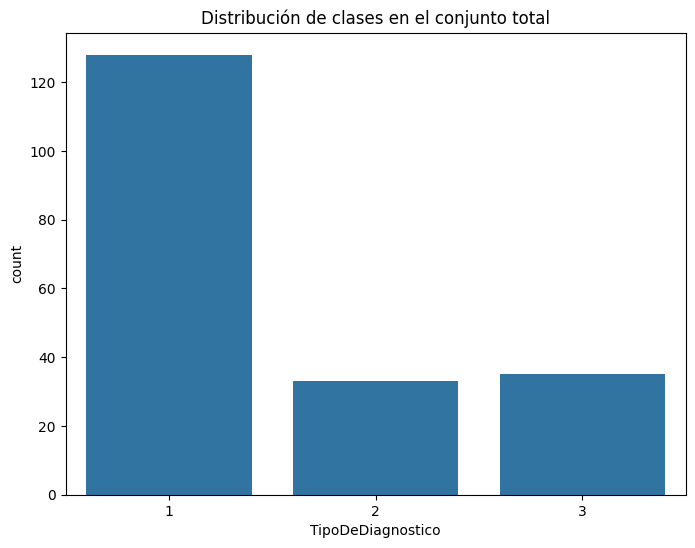

TipoDeDiagnostico
1    128
3     35
2     33
Name: count, dtype: int64


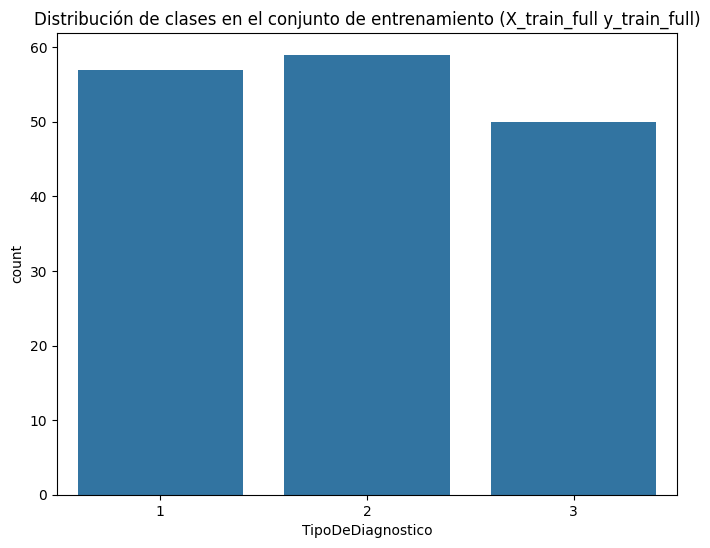

TipoDeDiagnostico
2    59
1    57
3    50
Name: count, dtype: int64


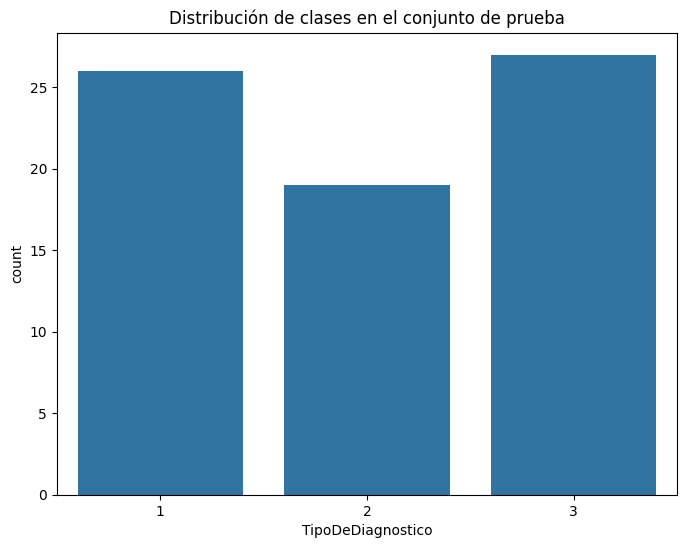

TipoDeDiagnostico
3    27
1    26
2    19
Name: count, dtype: int64


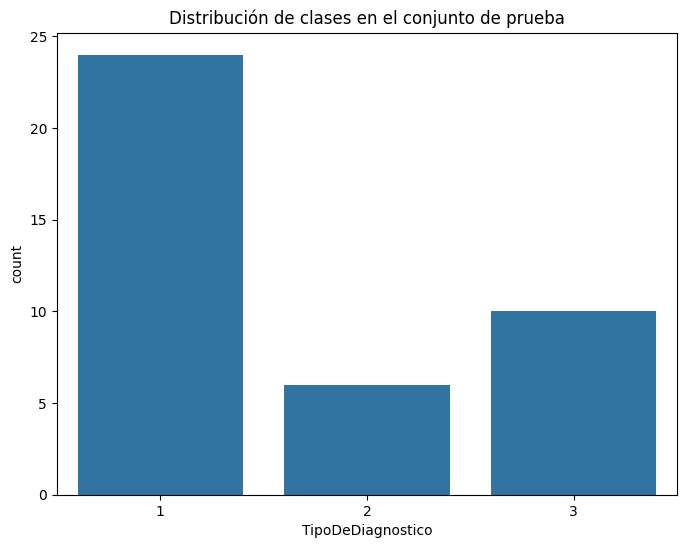

TipoDeDiagnostico
1    24
3    10
2     6
Name: count, dtype: int64


In [21]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: {X_test_full.shape}, Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_full)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_blind.value_counts())

In [22]:
param_grid = {
    'estimator__max_depth': [3, 5, 7, None],
    'estimator__min_samples_split': [2, 5, 10],  
    'estimator__min_samples_leaf': [1, 2, 4],  
    'estimator__max_features': ['sqrt', 'log2'],  
    'n_estimators': [10, 50, 100, 200],  
    'max_samples': [0.5, 0.75, 1.0],  
    'bootstrap': [True, False], 
    'bootstrap_features': [True, False], 
    'oob_score': [True, False],  
    'warm_start': [True, False] 
}
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

In [23]:
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator = bagging, 
    param_distributions=param_grid, 
    n_iter=50, 
    cv=cv_strategy, 
    random_state=42, 
    n_jobs=-1,
    scoring='f1',
    verbose=2
)


In [24]:
random_search.fit(X_train_full, y_train_full)
print("Mejores hiperparámetros encontrados:", random_search.best_params_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Mejores hiperparámetros encontrados: {'warm_start': True, 'oob_score': False, 'n_estimators': 50, 'max_samples': 0.75, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 3, 'bootstrap_features': True, 'bootstrap': False}


In [25]:
y_val_pred = random_search.predict(X_test_full)

print("Evaluación en el conjunto de validación:")
print(f"Accuracy: {accuracy_score(y_test_full, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_full, y_val_pred))


Evaluación en el conjunto de validación:
Accuracy: 0.8333
Precision: 0.8523
Recall: 0.8333
F1 Score: 0.8355

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.90      0.73      0.81        26
           2       0.68      0.89      0.77        19
           3       0.92      0.89      0.91        27

    accuracy                           0.83        72
   macro avg       0.84      0.84      0.83        72
weighted avg       0.85      0.83      0.84        72



In [26]:
y_test_blind_pred = random_search.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")


Evaluación en conjunto de prueba ciega:
Accuracy: 0.5250
Precision: 0.6544
Recall: 0.5250
F1 Score: 0.5713


In [27]:
y_test_pred = random_search.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred, average='weighted'):.4f}")


Evaluación en conjunto train original:
Accuracy: 0.7949
Precision: 0.8187
Recall: 0.7949
F1 Score: 0.8014


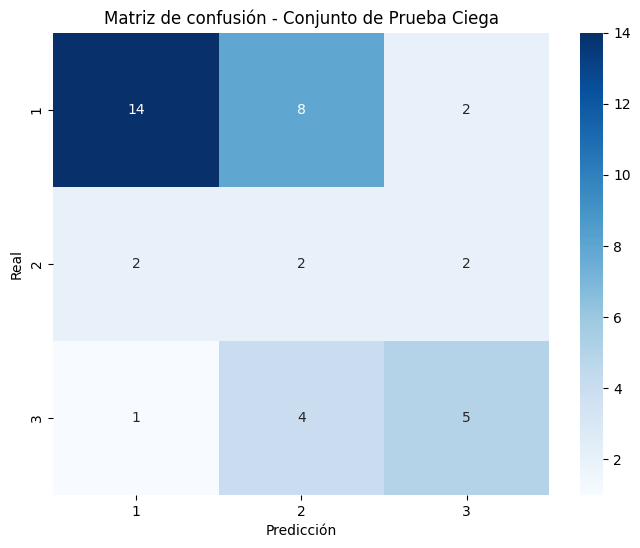

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predicciones del modelo
cm = confusion_matrix(y_test_blind, y_test_blind_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


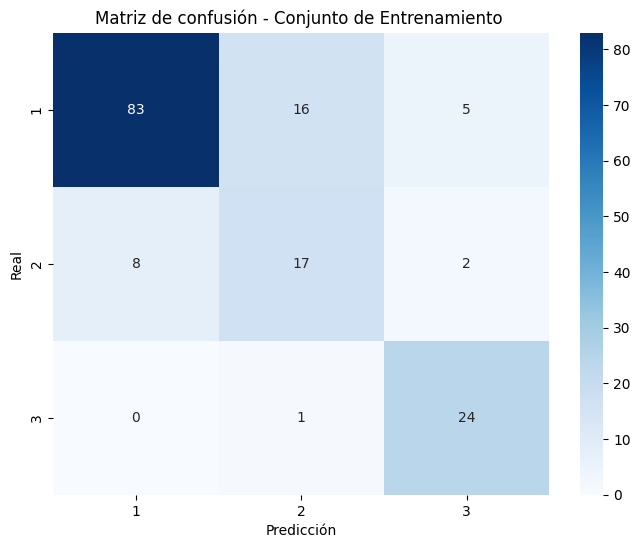

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


Características más importantes en BaggingClassifier:
longitud_relativa_11pm              0.079985
Puntuacion manecillas               0.072779
Números con error espacial          0.068192
Ángulo entre manecillas             0.063843
Round                               0.061027
Puntuacion contorno                 0.060339
puntuacion final                    0.055131
Números detectados correctamente    0.051590
Manecillas diferentes               0.050141
Total numeros detectados            0.046367
dtype: float64


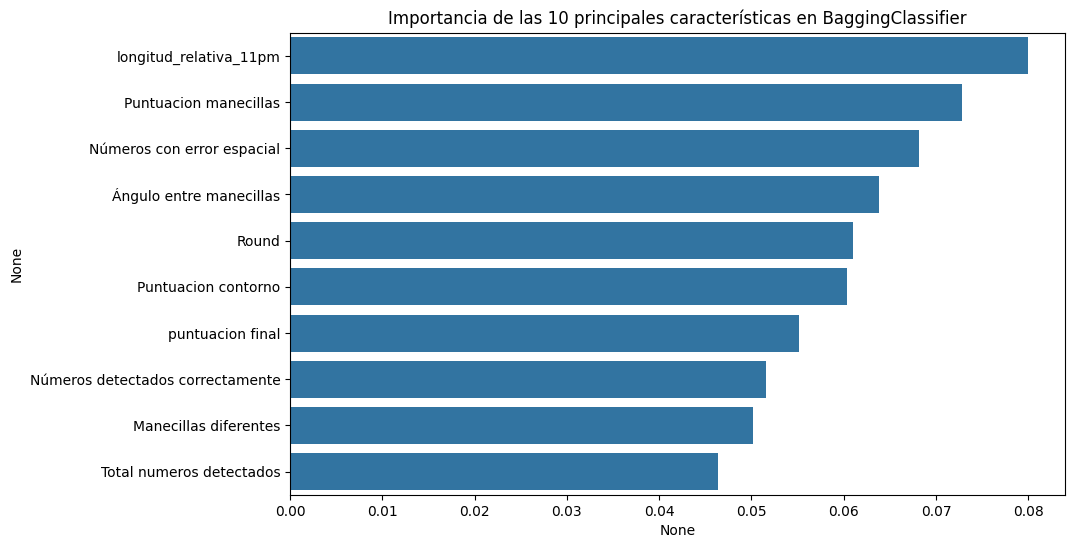

In [30]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in random_search.best_estimator_.estimators_
], axis=0)

importancias_bagging = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en BaggingClassifier:")
print(importancias_bagging.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_bagging.head(10), y=importancias_bagging.index[:10])
plt.title("Importancia de las 10 principales características en BaggingClassifier")
plt.show()


Características más importantes en BaggingClassifier:
longitud_relativa_11pm              1.000000
Puntuacion manecillas               0.901168
Números con error espacial          0.838257
Ángulo entre manecillas             0.778611
Round                               0.739991
Puntuacion contorno                 0.730556
puntuacion final                    0.659124
Números detectados correctamente    0.610558
Manecillas diferentes               0.590688
Total numeros detectados            0.538930
dtype: float64


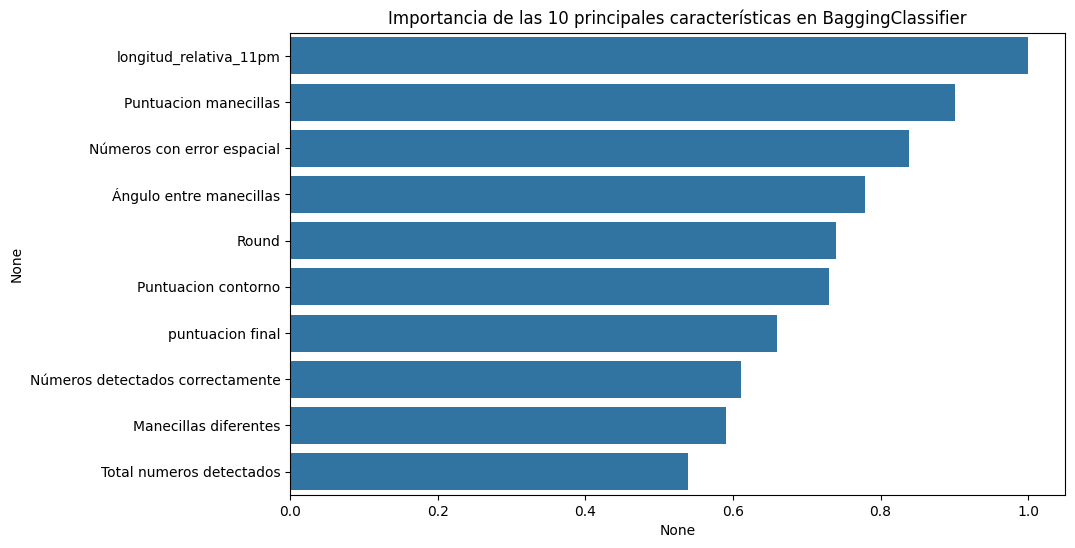

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in random_search.best_estimator_.estimators_
], axis=0)

importancias_bagging = pd.Series(feature_importances, index=X_train_full.columns)
importancias_bagging = (importancias_bagging - importancias_bagging.min()) / (importancias_bagging.max() - importancias_bagging.min())
importancias_bagging = importancias_bagging.sort_values(ascending=False)

print("Características más importantes en BaggingClassifier:")
print(importancias_bagging.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=importancias_bagging.head(10), y=importancias_bagging.index[:10])
plt.title("Importancia de las 10 principales características en BaggingClassifier")
plt.show()

df_importancias = pd.DataFrame({'Variable': importancias_bagging.index, 'Importance_Bagging': importancias_bagging.values})

